<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Description
This project uses the [consumer complaint database](https://catalog.data.gov/dataset/consumer-complaint-database).

## Data Description
The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database. The database generally updates daily.

## Purpose
Classify consumer complaints into predefined categories.

Classification algorithms
- Linear Support Vector Machine (LinearSVM)
- Random Forest
- Multinomial Naive Bayes 
- Logistic Regression.

# Imports

In [1]:
import time
time_start_notebook = time.time()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tqdm

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot') 

# random state
SEED=100

[(x.__name__,x.__version__) for x in [np,pd,sns,sklearn,tqdm]]

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[('numpy', '1.18.4'),
 ('pandas', '1.0.3'),
 ('seaborn', '0.9.0'),
 ('sklearn', '0.23.0'),
 ('tqdm', '4.46.0')]

In [3]:
import re
import string
import nltk
from nltk.corpus import stopwords

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

In [5]:
import multiprocessing as mp
from multiprocessing import  Pool
ncores = mp.cpu_count()

In [6]:
import dask
import dask.dataframe as dd
from dask.multiprocessing import get

In [7]:
[(x.__name__,x.__version__) for x in 
 [np,pd,sns,sklearn,tqdm,nltk,dask]]

[('numpy', '1.18.4'),
 ('pandas', '1.0.3'),
 ('seaborn', '0.9.0'),
 ('sklearn', '0.23.0'),
 ('tqdm', '4.46.0'),
 ('nltk', '3.2.5'),
 ('dask', '2.9.2')]

# Useful Functions

In [8]:
def parallelize_dataframe(df, func):
    ncores = mp.cpu_count()
    df_split = np.array_split(df, ncores)
    pool = Pool(ncores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Load the data

In [9]:
!ls ../data
! du -sh ../data/complaints.csv

complaints.csv       complaints.csv.zip   data_clean.csv       id_to_product.csv    small_complaints.csv
954M	../data/complaints.csv


In [44]:
df = pd.read_csv('../data/complaints.csv')
print(df.shape)

df.sample(n=2_000,random_state=SEED).to_csv('../data/complaints_2k.csv',index=False)
df.sample(n=5_000,random_state=SEED).to_csv('../data/complaints_5k.csv',index=False)

(1592522, 18)


In [45]:
df = pd.read_csv('../data/complaints_2k.csv')
df.head(2).append(df.tail(2))

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2014-07-09,Debt collection,Mortgage,Cont'd attempts collect debt not owed,Debt is not mine,NaN,NaN,WELLS FARGO & COMPANY,GA,30281,NaN,NaN,Postal mail,2014-07-14,Closed with explanation,Yes,No,930149
1,2017-12-02,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,Hello : ditech.com is my mortgage company. The...,NaN,Ditech Financial LLC,FL,331XX,NaN,Consent provided,Web,2017-12-02,Closed with explanation,Yes,NaN,2745073
1998,2015-12-09,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,The company is reporting to the credit bureau ...,Company believes it acted appropriately as aut...,"Pinnacle Credit Services, LLC",FL,320XX,NaN,Consent provided,Web,2015-12-09,Closed with explanation,Yes,No,1690051
1999,2019-11-20,Credit card or prepaid card,General-purpose prepaid card,Problem with a purchase or transfer,Card company isn't resolving a dispute about a...,I returned merchandise to a merchant in the am...,NaN,AMERICAN EXPRESS COMPANY,NY,NaN,NaN,Consent provided,Web,2019-11-20,Closed with explanation,Yes,NaN,3444586


# Data Manipulation

## Feature Selection
Here for the text analysis we will only consider two columns: Product and complaints.

In [12]:
# We are interested only in Product and consumer complaint narrative
# for this particular analysis.
df.columns

Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [13]:
cols = ['Product','Consumer complaint narrative']
df = df[cols]
df.columns = ['product','complaint']

df.head()

,product,complaint
0,Debt collection,NaN
1,Mortgage,Hello : ditech.com is my mortgage company. The...
2,Credit reporting,NaN
3,"Credit reporting, credit repair services, or o...",This a formal complaint against TransUnion reg...
4,Mortgage,NaN


## Remove NaNs

In [14]:
df = df.dropna(subset=['complaint'])
df.head()

,product,complaint
1,Mortgage,Hello : ditech.com is my mortgage company. The...
3,"Credit reporting, credit repair services, or o...",This a formal complaint against TransUnion reg...
5,"Credit reporting, credit repair services, or o...",I believe that an old account I had with XXXX ...
7,"Payday loan, title loan, or personal loan",I took out a title loan in XX/XX/2017 and didn...
9,Mortgage,A customer service agent from Ocwen Mortgage...


## Categorize products

In [15]:
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    217
Debt collection                                                                 138
Mortgage                                                                         65
Credit card or prepaid card                                                      51
Credit reporting                                                                 35
Student loan                                                                     26
Checking or savings account                                                      23
Bank account or service                                                          21
Credit card                                                                      20
Consumer Loan                                                                    15
Money transfer, virtual currency, or money service                               11
Vehicle loan or lease                                                       

In [16]:
df['product'].nunique()

16

In [17]:
"""
There are 18 different products. But if we look at closely, we see some redundant
categories. For example 'Money transfers' category is contained in 
'Money transfer, virtual currency, or money service'. We need to re create the categories.

""";

In [18]:
df['product'].unique()

array(['Mortgage',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Payday loan, title loan, or personal loan',
       'Credit card or prepaid card', 'Checking or savings account',
       'Vehicle loan or lease', 'Credit reporting', 'Debt collection',
       'Money transfer, virtual currency, or money service',
       'Student loan', 'Credit card', 'Money transfers',
       'Bank account or service', 'Payday loan', 'Consumer Loan',
       'Prepaid card'], dtype=object)

In [19]:
d = {
'Debt collection' : 'Debt collection',
'Mortgage': 'Mortgage',
'Credit reporting' : 'Credit reporting, credit repair services, or other personal consumer reports',
'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, credit repair services, or other personal consumer reports',
'Consumer Loan': 'Consumer Loan',
'Payday loan, title loan, or personal loan': 'Payday loan, title loan, or personal loan',
'Student loan': 'Student loan',
'Credit card or prepaid card': 'Credit card or prepaid card',
'Checking or savings account': 'Checking or savings account',
'Credit card': 'Credit card or prepaid card',
'Bank account or service': 'Bank account or service',
'Vehicle loan or lease': 'Vehicle loan or lease',
'Money transfer, virtual currency, or money service': 'Money transfer, virtual currency, or money service',
'Prepaid card' : 'Credit card or prepaid card',
'Money transfers': 'Money transfer, virtual currency, or money service', 
'Payday loan' : 'Payday loan, title loan, or personal loan',
'Other financial service': 'Other financial service',
'Virtual currency': 'Money transfer, virtual currency, or money service'
}

In [20]:
df['product'] = df['product'].map(d)
df.head(2)

,product,complaint
1,Mortgage,Hello : ditech.com is my mortgage company. The...
3,"Credit reporting, credit repair services, or o...",This a formal complaint against TransUnion reg...


In [21]:
dic_id_to_product = dict(enumerate(df['product'].unique()))
dic_id_to_product

{0: 'Mortgage',
 1: 'Credit reporting, credit repair services, or other personal consumer reports',
 2: 'Payday loan, title loan, or personal loan',
 3: 'Credit card or prepaid card',
 4: 'Checking or savings account',
 5: 'Vehicle loan or lease',
 6: 'Debt collection',
 7: 'Money transfer, virtual currency, or money service',
 8: 'Student loan',
 9: 'Bank account or service',
 10: 'Consumer Loan'}

In [22]:
# save the dictionary
pd.Series(dic_id_to_product).to_csv('../data/id_to_product.csv',index=False)

In [23]:
# !cat '../data/id_to_product.csv'

In [24]:
dic_product_to_id = {v:k for k,v in dic_id_to_product.items()}
dic_product_to_id

{'Mortgage': 0,
 'Credit reporting, credit repair services, or other personal consumer reports': 1,
 'Payday loan, title loan, or personal loan': 2,
 'Credit card or prepaid card': 3,
 'Checking or savings account': 4,
 'Vehicle loan or lease': 5,
 'Debt collection': 6,
 'Money transfer, virtual currency, or money service': 7,
 'Student loan': 8,
 'Bank account or service': 9,
 'Consumer Loan': 10}

In [25]:
df['category_id'] = df['product'].map(dic_product_to_id)
df.head(2)

,product,complaint,category_id
1,Mortgage,Hello : ditech.com is my mortgage company. The...,0
3,"Credit reporting, credit repair services, or o...",This a formal complaint against TransUnion reg...,1


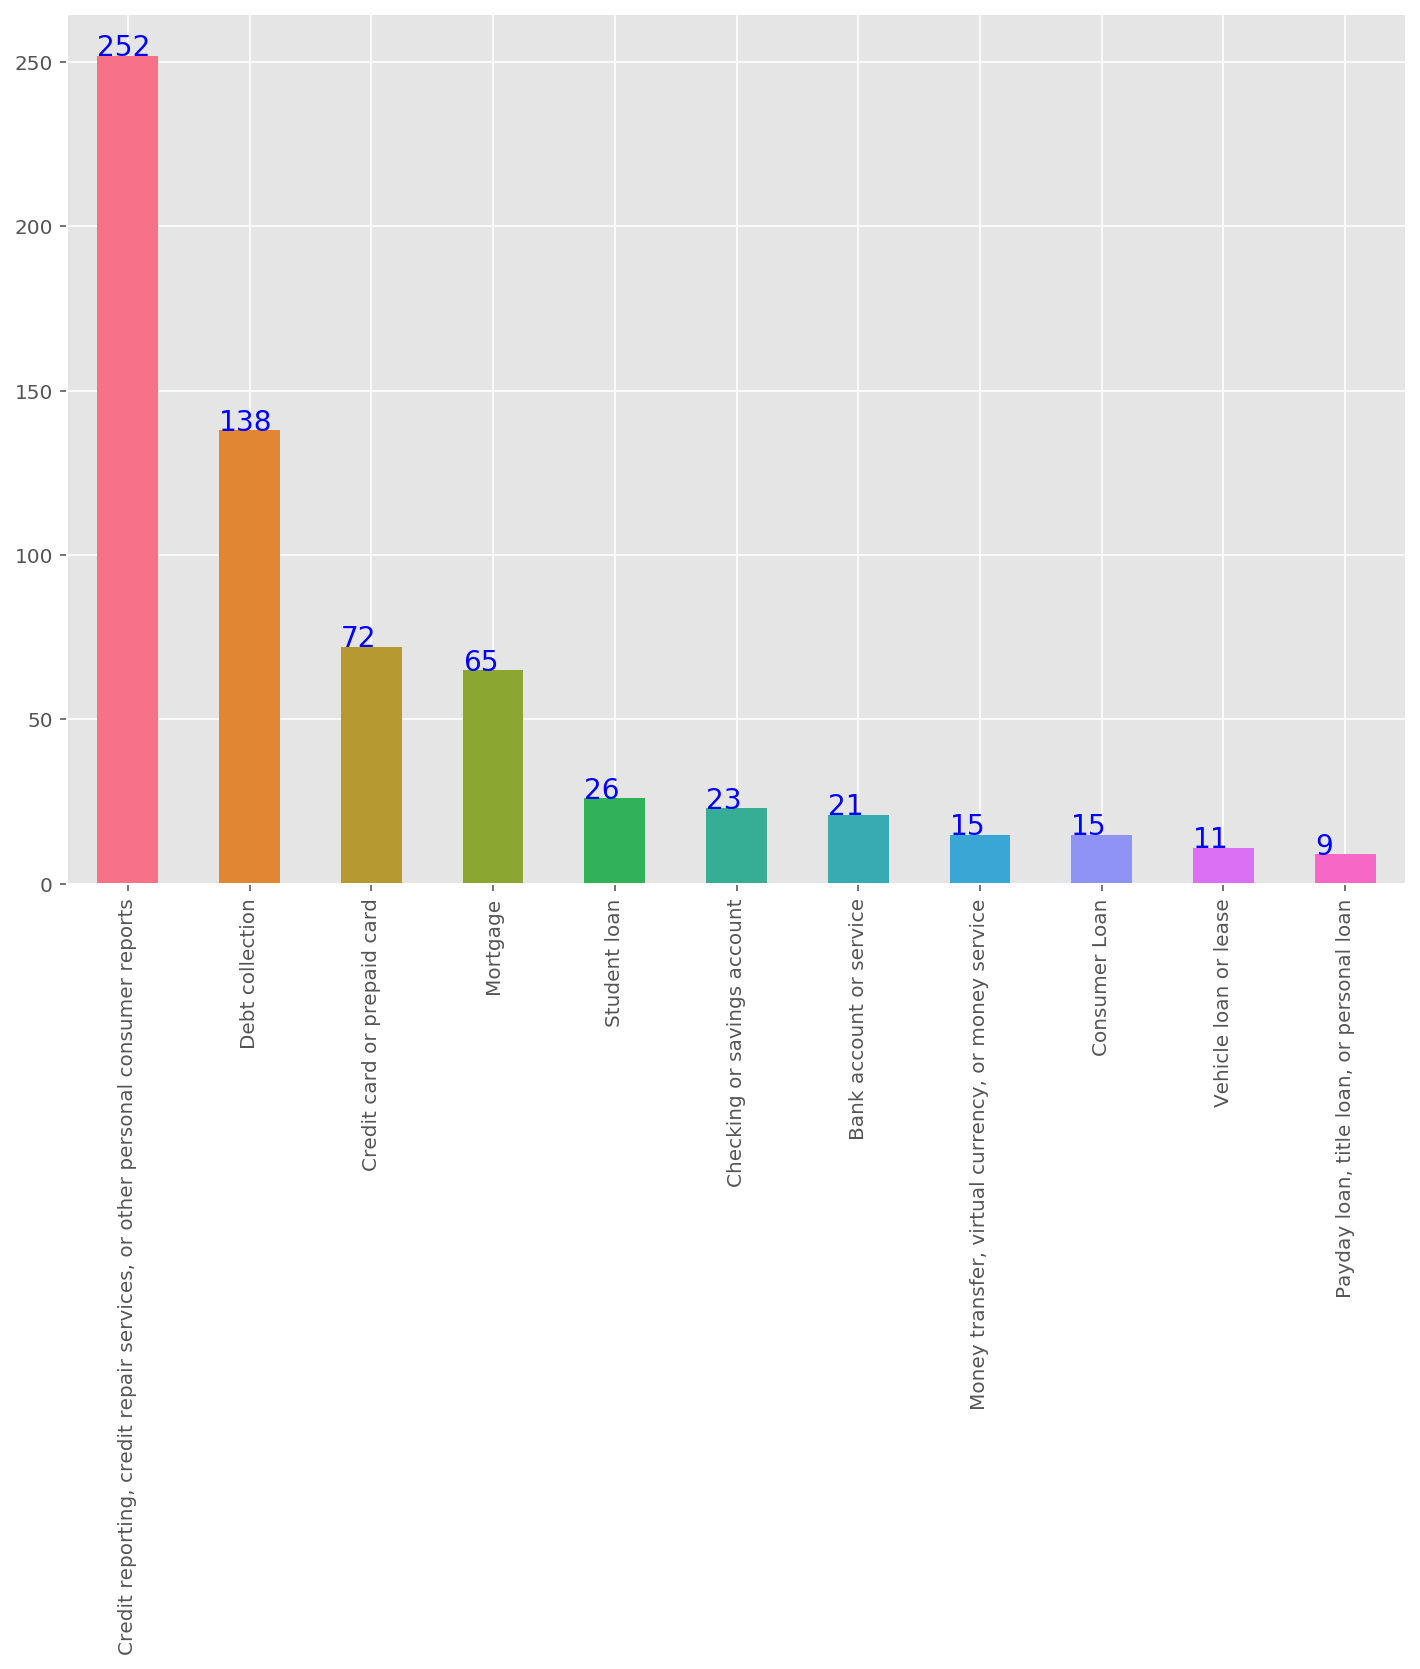

In [26]:
ax = df['product'].value_counts().plot.bar(
    figsize=(12,8),
    color=sns.color_palette('husl',
                            len(df['product'].value_counts())))

for p in ax.patches:
    x,y = p.get_x(), p.get_height()
    ax.text(x,y,f'{y:,.0f}',fontsize=14,color='blue')

# Text Processing

In [27]:
def process_text(text):
    """
    Do a basic text processing.

    Parameters
    -----------
    text : sentences of text
        
    Returns
    --------
    This function returns list with clean text.

    1: split combined text
    2: lowercase
    3: expand apostrophes
    4: remove punctuation
    5: remove digits
    6: remove repeated substring
    7: remove stop words
    8: lemmatize
    

    Example:
    ========
    import re
    import string
    from nltk.corpus import stopwords
    import nltk
    
    text = "I'm typing text2num! areYou ? yesyes pals"
    process_text(text)
    
    df['text_new'] = df['text'].apply(process_text)
    """
    show = False
    
    # make series
    ser = pd.Series([text])
    
    # step1: Split combined words areYou ==> are You
    s1 = ser.apply(lambda x: re.sub(r'([a-z])([A-Z])',r'\1 \2',x))

    # step2: lowercase
    s2 = s1.str.lower()

    # step3: expand apostrophes
    map_apos = {
        "you're": 'you are',
        "i'm": 'i am',
        "he's": 'he is',
        "she's": 'she is',
        "it's": 'it is',
        "they're": 'they are',
        "can't": 'can not',
        "couldn't": 'could not',
        "don't": 'do not',
        "don;t": 'do not',
        "didn't": 'did not',
        "doesn't": 'does not',
        "isn't": 'is not',
        "wasn't": 'was not',
        "aren't": 'are not',
        "weren't": 'were not',
        "won't": 'will not',
        "wouldn't": 'would not',
        "hasn't": 'has not',
        "haven't": 'have not',
        "what's": 'what is',
        "that's": 'that is',
    }

    s3a = pd.Series(s2.str.split()[0])
    s3b = s3a.map(map_apos).fillna(s3a)
    sentence = s3b.str.cat(sep=' ')
    s3 = pd.Series([sentence])

    # step4: remove punctuation
    s4 = s3.str.translate(str.maketrans(' ',' ',
                                        string.punctuation))
    # step5: remove digits
    s5 = s4.str.translate(str.maketrans(' ', ' ', '\n'))
    s5 = s5.str.translate(str.maketrans(' ', ' ', string.digits))

    # step6: remove repeated substring yesyes ==> yes
    s6 = s5.str.replace(r'(\w+)\1',r'\1',regex=True)

    # step7: remove stop words
    stop = set(stopwords.words('english'))
    s7 = s6.str.split()
    s7 = s7.apply(lambda x: [i for i in x if i not in stop])

    # step8: convert word to base form or lemmatize
    lemmatizer = nltk.stem.WordNetLemmatizer()
    s8 = s7.apply(lambda lst: [lemmatizer.lemmatize(word) 
                               for word in lst])

    if show:
        df_temp = pd.DataFrame([s,s1,s2,s3,s4,s5,s6,s7,s8])
        df_temp.index = ['0: Original',
                             '1: CombinedWords',
                             '2: Lowercase',
                             '3: Apostrophes',
                             '4: Punctuation',
                             '5: Digits',
                             '6: RepeatedWords',
                             '7: List',
                             '8: StopWords',
                             '9: Lemmatize'
                            ]
        display(df_temp)
    return s8

text = "I'm typing text2num! areYou ? yesyes pals"
process_text(text)

0    [typing, textnum, yes, pal]
dtype: object

# Parallel Processing the Text

In [28]:
# %%time
# df['complaint_lst'] = df['complaint'].apply(process_text)

In [29]:
# def add_features(df):
#     df['complaint_lst'] = df['complaint'].apply(process_text)

#     return df

In [30]:
# %%time
# df = parallelize_dataframe(df, add_features)

In [31]:
# ncores = mp.cpu_count()
# ddf = dd.from_pandas(df, npartitions=ncores)

In [32]:
# ddf.head(2)

In [33]:
# def dask_this(ddf):
#     res = ddf['complaint'].apply(process_text)
#     return res

In [34]:
# %%time
# res = ddf.map_partitions(dask_this).compute(
#     scheduler='processes',num_workers=ncores)

# ddf.compute()['complaint_lst'] = res

In [35]:
# type(ddf), type(res)

In [36]:
# res.head()

In [37]:
# df['complaint_clean'] = df['complaint_lst'].str.join(sep=' ')

In [38]:
from tqdm import tqdm
tqdm.pandas(desc="my bar!")

df['complaint_lst'] = df['complaint'].progress_apply(process_text)
df['complaint_clean'] = df['complaint_lst'].str.join(sep=' ')

/Users/poudel/miniconda3/envs/dataSc/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
my bar!: 100%|██████████| 647/647 [00:02<00:00, 240.65it/s]


In [39]:
df.head(2)

,product,complaint,category_id,complaint_lst,complaint_clean
1,Mortgage,Hello : ditech.com is my mortgage company. The...,0,"[helo, ditechcom, mortgage, company, placed, a...",helo ditechcom mortgage company placed automat...
3,"Credit reporting, credit repair services, or o...",This a formal complaint against TransUnion reg...,1,"[formal, complaint, trans, union, regarding, i...",formal complaint trans union regarding inacura...


# Save clean data for modelling

In [40]:
df.to_csv('../data/data_clean.csv',index=False)

In [41]:
!ls ../data

complaints.csv       complaints.csv.zip   data_clean.csv       id_to_product.csv    small_complaints.csv


# Total Time Taken

In [42]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 0 min 17 secs
